<a href="https://colab.research.google.com/github/QuantumQist/Kawa_w_Teorii/blob/main/Hopfield_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import copy

import matplotlib.animation as animation

# Hopfield networks

This notebook implements a Hopfield network capable of storing pictures with the symbols of 'X' and 'O'.
The pixels of each image are represented by a single bit.

Source paper: J.J. Hopfield,   Neural networks and physical systems with emergent collective computational abilities., Proc. Natl. Acad. Sci. U.S.A. 79 (8) 2554-2558, https://doi.org/10.1073/pnas.79.8.2554 (1982).



# 1. Images to store.

The cell below defines the letters to be stored.

In [2]:
# Make letters
O = np.array([
    [0,1,1,1,0],
    [1,0,0,0,1],
    [1,0,0,0,1],
    [1,0,0,0,1],
    [0,1,1,1,0]
])
X = np.array([
    [1,0,0,0,1],
    [0,1,0,1,0],
    [0,0,1,0,0],
    [0,1,0,1,0],
    [1,0,0,0,1]
])
letters = [O, X]

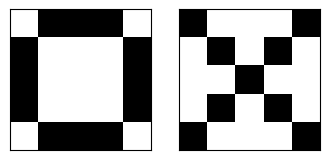

In [3]:
fig, axs = plt.subplots(ncols=2, nrows = 1, figsize = (4, 5))
for idx, ax in enumerate(axs):
    ax.imshow(letters[idx], cmap = "gray_r")
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In this notebook, we will corrupt this image. The network is not informed about which pixels are corrupted.

# 2. Define the class with the network and methods.

The class below defines the Hopfield network and the following key methods:
* `self.establish connections()` - this method defines the conenections between neurons stored in `self.connections`. Let's denote it by matrix $T$. Its diagonal elements are zeros
$$T_{ii}=0.$$
Its off-diagonal elements can be computed from the vectors representing the data denoted by $V^s$. We obtain them by flattening the image from a 2D matrix into 1D vector.
The offdiagonal elements are
$$T_{ij} = \sum_s (2V_i^s - 1)(2V_j^s - 1),$$
where $2V_i^s$ is $i$-th pixel in the image indexed by $s$. The sum goes over all images. We can rewrite this expression in terms of a matrix element of an outer product of the following operator
$$\tilde{T}=\sum_s(2|V^s\rangle - |1\rangle)(2\langle V^s| - \langle 1|),$$
where $|1\rangle$ is a vector with ones everywhere and same shape as $|V^s\rangle$ - a flat column vector representing an image. Then
$$T_{ij} = \langle i | \tilde{T} | j \rangle.$$
In the end $\tilde{T}$ has the same off-diagonal elements as as $T$.
The following procedure leads to efficient computation of the neuron connections
    * Compute $T=\sum_s(2|V^s\rangle - |1\rangle)(2\langle V^s| - \langle 1|)$
    * Set the diagonal elements of T to 0.

* `self.compute_energy(pixels)` - computes the energy function assigned to the Hopfield network given the provided pixel (neuron) values. If the matrix $T$ represents the connections and $V$ represents an image, then we can compute the enrgy function from
$$E = - \frac{1}{2}\sum_{i} \sum_{j} T_{ij} V_i V_j.$$
There is no summation over $s$ here, as the energy is computed for a specific image.

* `self.retrieve_image()` - retrieves an image from memory based on its corrupted version. This method tracks the network energy during the retrieval process. The algorithm is described in the next section.
Before we perform it, we first corrupt the image based on selected corruption method and implement the following choices from which we can choose by setting the `corruption_type` argument
    * `random_eraser` - we set randomly selected neurons to $0$.
    * `random_noise` - we flip the values of randomly selected bits.
    * `mask` - we keep top part of the image (10 pixels) and set the bottom part to $0$.

# 3. Retrieval process.

Suppose we want to retrieve image from memory given the connections described by matrix $T$. We are given a corrupted version of that image $V^c$.
We perform the following algorithm:
1. Instantiate the neurons using the $V^c$ values $$V\leftarrow V_c.$$
2. Pick a random neuron $i$. Compute the criterion
$$C = \sum_j T_{ij} V_j.$$
3. If $C>0$, set the selected pixel value to $1$. Set it to $0$ otherwise.
$$\begin{cases}
V_i ← 1 \quad \text{if} \quad C > 0 \\
V_i ← 0 \quad \text{if} \quad C \leq 0.
\end{cases}$$
4. Repeat step 2 & 3 until we converge to the final image.

To stabilize the protocol, we fix the total number of allowed repetitions by `total_step_limit`. We also check the convergence by verifiying if any pixel was changed within the last few steps given by `flat_check`. If the pixels are not updated for a long time, we break out of the loop.

In [4]:
class Hopfield():
    def __init__(self, data = letters):
        self.shape = data[0].shape
        self.size = self.shape[0] * self.shape[1]
        self.connections = np.zeros((self.size, self.size))
        self.data = data
        self.establish_connections(data)
        self.energy_list = []

    def establish_connections(self, data):
        """
        Establish connections between neurons.

        Data is the list with data to store.
        """
        # Loop over data
        for s in data:
            s_flat = s.flatten()
            s_flat = 2 * s_flat - 1
            self.connections += np.outer(s_flat, s_flat)
        # Set diagonal elements to zero
        np.fill_diagonal(self.connections, 0)

    def reset_energy_list(self):
        self.energy_list = []

    def compute_energy(self, pixels):
        """
        Compute the energy of a state based on the Hopfiled network and
        provided state of pixels.
        """
        return -0.5 * np.dot(pixels, np.dot(self.connections, pixels))

    def plot_network_representation(self):
        """
        Plots the representation of the neural network.
        """
        x_s = [np.cos(2 * np.pi * n / self.size) for n in range(self.size)]
        y_s = [np.sin(2 * np.pi * n / self.size)  for n in range(self.size)]
        fig, ax = plt.subplots(figsize = (8, 8))
        ax.scatter(x_s, y_s, color = "black", s = 100, zorder = 1)
        ax.axis("off")
        ax.set_xlim(-1.1, 1.1)
        ax.set_ylim(-1.1, 1.1)
        ax.set_aspect("equal")

        max_val = np.max(np.abs(self.connections))
        norm = plt.Normalize(vmin = 0, vmax = max_val)
        for i in range(self.size):
            for j in range(self.size):
                color = plt.cm.YlGn(norm(self.connections[i,j]))
                ax.plot([x_s[i], x_s[j]], [y_s[i], y_s[j]], color = color, linewidth = 1, zorder = 0)
        plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='YlGn'), ax=ax,
             orientation='horizontal', fraction=0.046, pad=0.04, extend='both')
        plt.show()

    def retrieve_image(self,
                       image_idx,
                       corrupted_pixels = 8,
                       total_step_limit = 1000,
                       flat_check = 100,
                       save_file_name = None,
                       corruption_type = "random_eraser"):
        """
        Retrieve an image from the network's memory.
        First two rows are unchanges, the rest rows will be retrieved.
        One pixel is randomly

        image_idx: index of the image to retrieve.
        """
        self.reset_energy_list()
        ### Prepare and visualize data
        image = self.data[image_idx]
        image_flat = image.flatten()
        if corruption_type == "random_noise":
            # Pick random pixels and flip their values
            random_pixels = np.random.choice(self.size, corrupted_pixels, replace = False)
            for pixel in random_pixels:
                image_flat[pixel] = (image_flat[pixel] + 1) % 2
        if corruption_type == "random_eraser":
            # Pick random pixels and set them to 1
            random_pixels = np.random.choice(self.size, corrupted_pixels, replace = False)
            for pixel in random_pixels:
                image_flat[pixel] = 0
        if corruption_type == "mask":
            # Set the values of first 10 pixels to 0
            for idx in range(10, self.size):
                image_flat[idx] = 0

        # Get initial energy
        self.energy_list.append(self.compute_energy(image_flat))

        ### Retrieve the corrupted pixels
        # Counter to keep the total number of with no change in image
        steps_unchanged = 0

        # Show original, corrupted, and retrieved image
        fig, axs = plt.subplots(ncols=3, nrows = 1, figsize = (10, 5))
        axs[0].imshow(image, cmap = "gray_r")
        axs[0].set_title("Original image")
        axs[1].imshow(image_flat.reshape(self.shape), cmap = "gray_r")
        axs[1].set_title("Corrupted image")

        # Store the initial frame
        if save_file_name is not None:
            frames = [ copy.deepcopy(image_flat).reshape(self.shape),]

        for step in range(total_step_limit):
            # Pick a random pixel
            i = np.random.choice(self.size)
            # Get pixel value before the update
            pixel_before = image_flat[i]
            # Compute the update criterion
            criterion = np.sum(self.connections[i, :] * image_flat)
            # Update the pixel
            image_flat[i] = 1 if criterion > 0 else 0
            # Get pixel value after the change
            pixel_after = image_flat[i]
            # Check if the pixel has changed
            if pixel_before == pixel_after:
                steps_unchanged += 1
            else:
                steps_unchanged = 0

            if save_file_name is not None:
                new_image = copy.deepcopy(image_flat)
                new_image = new_image.astype(float)
                # Change pixel types to floats
                new_image[i] = 0.3
                new_image = new_image.reshape(self.shape)
                frames.append(new_image)

            # Append energy
            self.energy_list.append(self.compute_energy(image_flat))

            # Break out of the loop if the umage was not updated for long
            if steps_unchanged >= flat_check:
                print(f"Steps performed: {step}")
                print(f"Image was not updated for {flat_check} steps.")
                break

        # Show the retrieved image
        axs[2].imshow(image_flat.reshape(self.shape), cmap = "gray_r")
        axs[2].set_title("Retrieved image")
        plt.show()

        if save_file_name is not None:
            print("Final plot in the animation:")
            fig, ax = plt.subplots()
            # Turn ticks off
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect("equal")
            im = ax.imshow(frames[0], animated=True, cmap = "gray_r")
            def animate(i):
                im.set_array(frames[i])
                return im,

            ani = animation.FuncAnimation(fig, animate, frames=len(frames), interval=200, blit=True)
            ani.save(save_file_name, writer='ffmpeg', fps=10)
            plt.show()

        plt.plot(self.energy_list, "-o")
        plt.xlabel("Step")
        plt.ylabel("Energy")
        plt.show()

In [5]:
hopfield_net = Hopfield()

hopfield_net.establish_connections(letters)

**Plot the network representation**

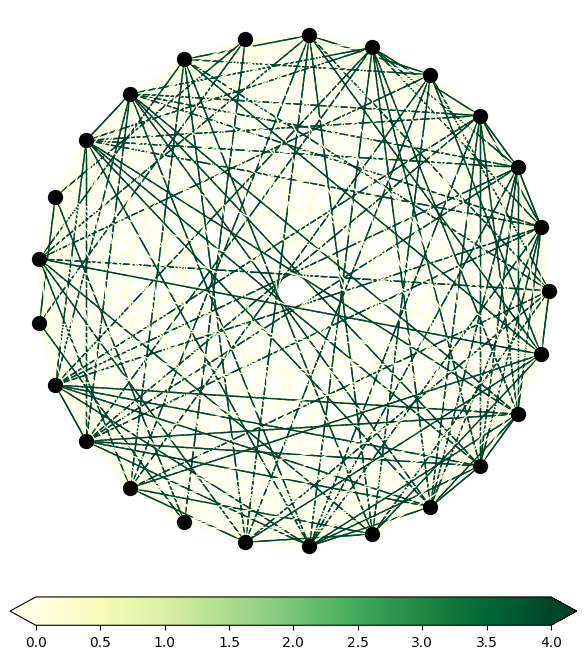

In [6]:
hopfield_net.plot_network_representation()

Steps performed: 143
Image was not updated for 100 steps.


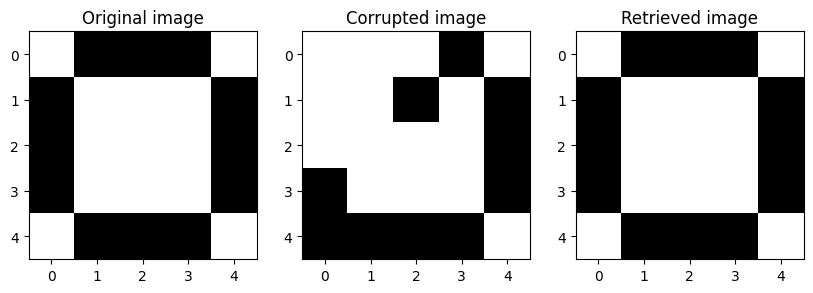

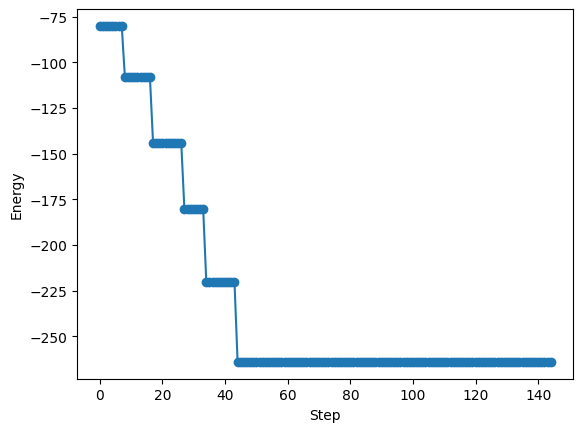

In [7]:
hopfield_net.retrieve_image(
    image_idx = 0,
    corrupted_pixels = 6,
    corruption_type="random_noise",
    #save_file_name = "random_eraser_o.mp4")
    save_file_name = None)

Steps performed: 166
Image was not updated for 100 steps.


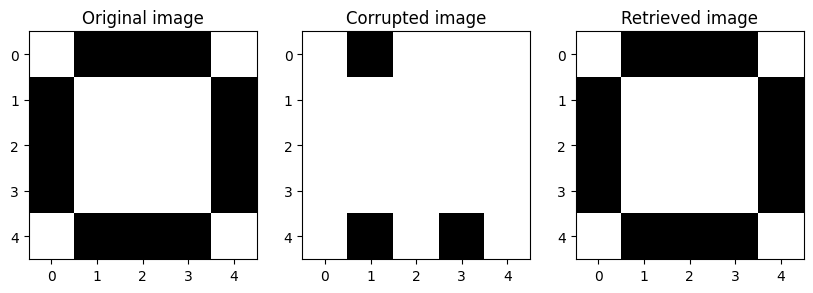

Final plot in the animation:


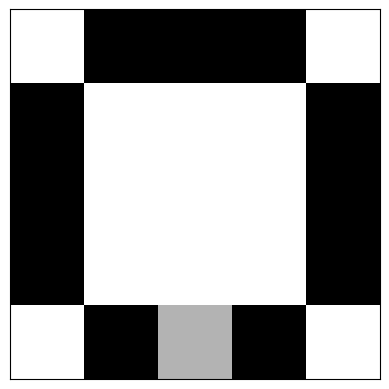

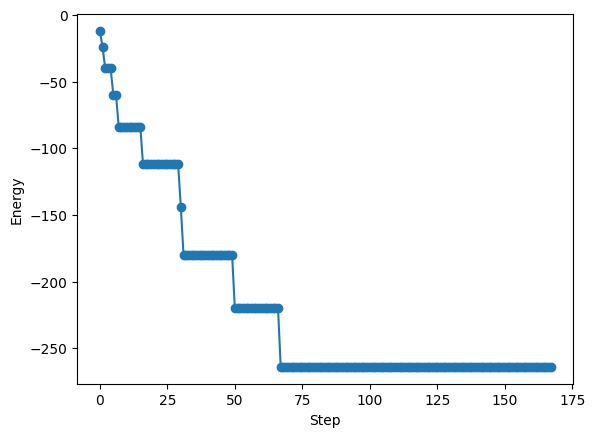

In [8]:
hopfield_net.retrieve_image(
    image_idx = 0,
    corrupted_pixels = 20,
    corruption_type="random_eraser",
    save_file_name = "random_eraser.mp4")

Steps performed: 145
Image was not updated for 100 steps.


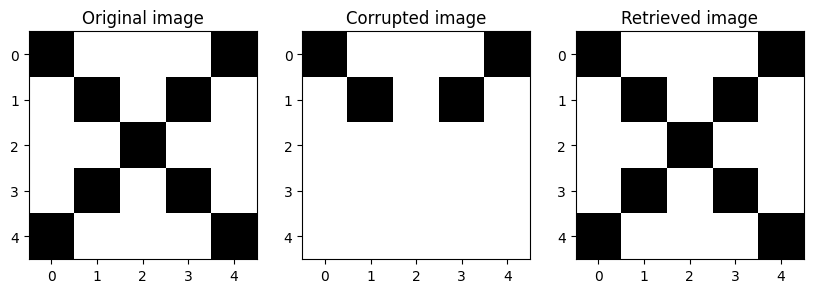

Final plot in the animation:


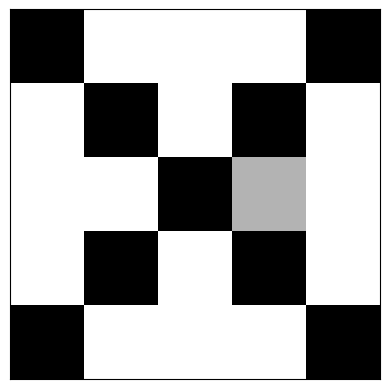

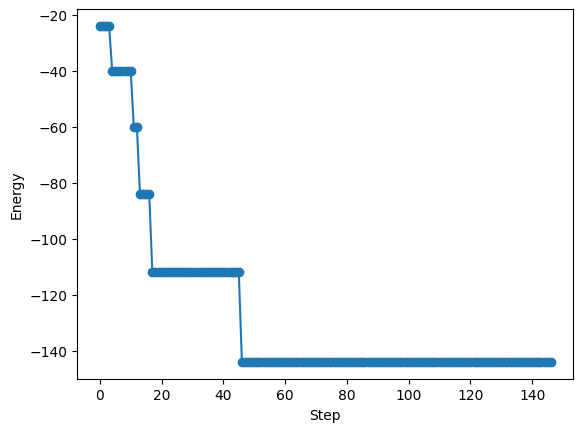

In [9]:
hopfield_net.retrieve_image(
    image_idx = 1,
    corruption_type="mask",
    save_file_name = "mask.mp4"
    )